## Policy Gradient Implementations - REINFORCE with Average MC return baseline
###  Continuous Actions case

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import wrappers
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:

class PolicyNetwork(nn.Module):  
    def __init__(self,num_states, num_actions, hidden_size):
        super(PolicyNetwork,self).__init__()
        self.num_states = num_states
        self.num_actions = num_actions
        
        #Policy Network
        self.policy_linear1 = nn.Linear(num_states,hidden_size)
        self.policy_linear2 = nn.Linear(hidden_size,hidden_size)
        self.policy_linear3 = nn.Linear(hidden_size,num_actions)
        
        
    def forward(self,state):
        x1 = self.policy_linear1(state)
        x1 = F.relu(x1)
        x1 = self.policy_linear2(x1)
        x1 = F.relu(x1)
        x1 = self.policy_linear3(x1)
        mu_out = torch.tanh(x1)
        var_out = F.softplus(x1)
        return mu_out,var_out


    
    

In [3]:
def update_gradients(gamma,ep_rewards,ep_logits,ep_entropies):
    mc_return = []
    p_loss = []
    loss=0
    G = 0
    for r in reversed(range(len(ep_rewards))):
        G = ep_rewards[r] + gamma*G
        mc_return.insert(0,G)
    mc_return = torch.tensor(mc_return)
    advantage_returns = (mc_return - mc_return.mean())/mc_return.std()
    #print((mc_return))
    for lp, re in zip(ep_logits, advantage_returns):
        p_loss.append( - lp * re)
    
    optim_policy.zero_grad() 
    #trying entropy regularization
    #print(ep_entropies)
    loss = torch.stack(p_loss).sum() + 0.0001*ep_entropies
    loss.backward()
    #plot_grad_flow_v2(p_net.named_parameters())
    optim_policy.step()

    


In [4]:
def train(env):
    gamma = 0.99
    max_episodes = 4000
    max_steps = 5000
    running_reward = 0
    plot_rewards = []
    for ep in range(max_episodes):
        ep_rewards =[]
        ep_logits = []
        ep_entropies = []

        current_reward = 0
        state = env.reset()
        
        for step in range(max_steps):
            #print(type(state))
            state = torch.from_numpy(state).float().unsqueeze(0)
        
            mu_out,var_out = p_net.forward(state)
            #print(mu_out,var_out)
            #Sample next action according normal distribution we trying to fit
            dist_obj = Normal(mu_out[0],var_out[0])
            sampled_action_tensor = dist_obj.sample()
            sampled_action = np.clip(sampled_action_tensor.detach().numpy(),-1,1)
            #print(sampled_action,"/n")
            next_state,reward,done,_ = env.step(sampled_action)
            log_prob = dist_obj.log_prob(sampled_action_tensor)
            
            entropy = dist_obj.entropy()
            ep_rewards.append(reward)
            ep_logits.append(log_prob)
            ep_entropies.append(entropy)
            current_reward += reward
            state = next_state
            if done:
                break
            
        running_reward = 0.05 * current_reward + (1 - 0.05) * running_reward
        if ep%100==0:
            print(ep)
            print("Running reward = ",running_reward)
        plot_rewards.append(running_reward)
        #Update the parameters
        ep_entropies = torch.cat(ep_entropies)
        update_gradients(gamma,ep_rewards,ep_logits,ep_entropies.sum())
        writer.add_scalar("Reward ",running_reward)
        if running_reward >env.spec.reward_threshold:
            print("Solved in ",ep)
    return plot_rewards, dist_obj
    
        

### Initiate

In [5]:
#device = set_device()
p_net = PolicyNetwork(8,2,256)
optim_policy= optim.Adam(p_net.parameters(), lr=9e-4)
writer = SummaryWriter()
p_net.train()
env = gym.make('LunarLanderContinuous-v2')
env.seed(223)
plot_rewards, dist_obj = train(env)
writer.flush()
env.close()

0
Running reward =  -15.998954625581717
100
Running reward =  -283.15891990341976
200
Running reward =  -180.7568360920668
300
Running reward =  -104.17879208943522
400
Running reward =  -61.150298633167786
500
Running reward =  -34.49405930880422
600
Running reward =  -24.958984693123995
700
Running reward =  -59.94925746704198
800
Running reward =  7.188733355850732
900
Running reward =  41.4612412510419
1000
Running reward =  -83.40972217011624
1100
Running reward =  -79.2843943775053
1200
Running reward =  8.098799483185804
1300
Running reward =  20.19650396325632
1400
Running reward =  5.423455749569729
1500
Running reward =  -8.851955399337998
1600
Running reward =  -5.299342610793943
1700
Running reward =  -66.36293037833894
1800
Running reward =  -31.898334548262422
1900
Running reward =  -49.47875422967405
2000
Running reward =  -115.49792301197255
2100
Running reward =  -104.0271110384195
2200
Running reward =  -106.00761710026569
2300
Running reward =  -141.06643357090525
24

### Plot  (REINFORCE with baseline is not so good for continuous action domains)

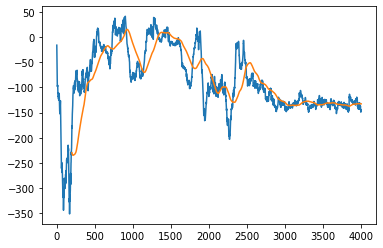

In [10]:
plt.plot(np.arange(0,4000),plot_rewards)
plt.plot(np.arange(0,4000),pd.Series(plot_rewards).rolling(200).mean())
plt.show()